# Sentiement Analysis of IMDB Movie Reviews
## Caoimhe Rooney

Problem objective:
Do a thorough Exploratory Data Analysis of the dataset and report the final performance metrics for your approach. Suggest ways in which you can improve the model.

NLP Challenge: IMDB Dataset of 50K Movie Reviews to perform Sentiment analysis

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# from wordcloud import WordCloud,STOPWORDS
# from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
# from bs4 import BeautifulSoup
# import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
# from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from textblob import TextBlob,Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

import warnings
warnings.filterwarnings('ignore')

### Import training dataset

In [2]:
# import the training data
imdb_data=pd.read_csv('data/IMDB Dataset.csv')
print(imdb_data.shape)

# view first 15 entries of dataset
imdb_data.head(15)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
# Print summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
# remove duplicates
imdb_data['dup'] = imdb_data.duplicated(subset=None,keep='first')
del imdb_data['dup']

In [5]:
# Count how many of each sentiment is present in the dataset.
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

The dataset includes a balance between positive and negative sentiments.

<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='sentiment'>

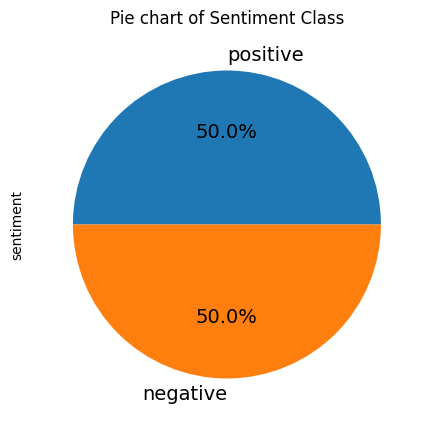

In [6]:
# visualise class balance
pie=pd.DataFrame(imdb_data['sentiment'].replace(0,'Negative').replace(1,'Positive').value_counts())
pie.reset_index(inplace=True)
pie.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie['index'], legend = False, fontsize=14, figsize=(5,5))

### Pre-processing
We wish to pre-process the dataset to improve the quality of the text and make it suitable for machines to process.

We will clean the text by 
- remove html tags,
- remove URLs,
- remove punctuation,
- removing special characters,
- set to lowercase,
- removing stopwords,
- stemming.

### Remove html tags

In [11]:
# Removing html tags
def strip_html_tags(text):
    html = re.compile('<.*?>') 
    text = html.sub(r'',text) #Removing html tags
    return text

In [12]:
# example of html tag removal
text = imdb_data['review'][1][:70]
print(f"Before removing HTML tags: {text}")
new_text = strip_html_tags(text)
print(f"After removing HTML tags : {new_text}")

Before removing HTML tags: A wonderful little production. <br /><br />The filming technique is ve
After removing HTML tags : A wonderful little production. The filming technique is ve


### Remove URLs

In [9]:
# Removing URLs
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [13]:
# example of URL removal
text = 'My website link: https://www.mathematigals.com/caoimhe-rooney'
print(f'Text before removing URL: {text}')
print(f'Text after removing URL : {remove_url(text)}')

Text before removing URL: My website link: https://www.mathematigals.com/caoimhe-rooney
Text after removing URL : My website link: 


### Remove punctuation

In [15]:
# remove punctuation
import string
exclude = string.punctuation

def remove_punc(text):
    text = text.translate(str.maketrans('', '', exclude))
    return text

In [16]:
# example of punctuation removal
text = 'Hello! My name is Caoimhe.'
print(f'Text before punctuation: {text}')
text_wihout_punc = remove_punc(text)
print(f'Text after punctuation : {text_wihout_punc}')

Text before punctuation: Hello! My name is Caoimhe.
Text after punctuation : Hello My name is Caoimhe


### Remove special characters

In [17]:
def remove_special_characters(text):
#     pattern=r'[^a-zA-Z0-9\s]'
    text=re.sub(r'[^a-zA-Z0-9\s]',' ',text)
    return text

### Set to lowercase

In [18]:
def to_lower(text):
    return text.lower()  

In [19]:
# example of setting to lowercase
print(f"Before applying lower casing: {text}")
new_text = to_lower(text)
print(f"After applying lower casing : {new_text}")

Before applying lower casing: Hello! My name is Caoimhe.
After applying lower casing : hello! my name is caoimhe.


### Remove spelling errors

In [20]:
from textblob import TextBlob

def fix_spelling(text):
    text_ = TextBlob(text)
    return text_.correct().string

In [21]:
# example of correcting spelling
text = 'thiss sentance has lotts of spelingg erors'
text_ = fix_spelling(text)
print(f'Correct text: {text_}')

Correct text: this sentence has lots of spelling errors


### Removing stopwords

In [22]:
sw = stopwords.words('english')

#removing the stopwords
def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word in sw:
            continue
        else:
            new_text.append(word)    
    output = ' '.join(new_text)
    return output

In [23]:
# example of removing stopwords
text = 'We want to remove the stop words that are commonly used words in a language'

print(f'Text before removing stop words: {text}')
print(f'Text after removing stop words : {remove_stopwords(text)}')

Text before removing stop words: We want to remove the stop words that are commonly used words in a language
Text after removing stop words : We want remove stop words commonly used words language


### Text stemming

In [24]:
# Stemming the text
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [25]:
# example of stemming
text = 'stem stems stemmed stemming'
stemmer(text)

'stem stem stem stem'

### Tokenization
Process of breaking data into smaller chunks of information.
We can use tokenization to separate sentences or words.

In [26]:
# tokenization of text
tokenizer = ToktokTokenizer()

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

In [27]:
# example of tokenization
new_text = tokenize(text)
print(f"After applying tokenizing : {new_text}")

After applying tokenizing : ['stem', 'stems', 'stemmed', 'stemming']


## Apply the pre-processing steps to the reviews

In [28]:
# Clean the dataset with functions defined above
def clean(dataset, html_tags=True, urls=True, punctuation=True, special_char=True, 
          lower=True, spelling=True, stemming=True, stopwords=True, tokens=True):
    if html_tags:
        print('Stripping html tags...')
        dataset = dataset.apply(strip_html_tags)

    if urls:
        print('Removing URLs...')
        dataset = dataset.apply(remove_url)
        
    if punctuation:
        print('Removing punctuation...')
        dataset = dataset.apply(remove_punc)
        
    if special_char:
        print('Removing special characters...')
        dataset = dataset.apply(remove_special_characters)
    
    if lower:
        print('Converting to lower case...')
        dataset = dataset.apply(to_lower)
        
    if spelling:
        print('Removing spelling errors...')
        dataset = dataset.apply(fix_spelling)
        
    if stopwords:
        print('Removing stopwords...')
        dataset = dataset.apply(remove_stopwords)
     
    if stemming:
        print('Stemming text...')
        dataset = dataset.apply(stemmer)
    
    if tokens:
        print('Tokenizing text...')
        dataset = dataset.apply(tokenize)
    
    print('Done.')
    return dataset

In [29]:
# clean reviews in dataset
imdb_data['prep'] = clean(imdb_data['review'],spelling=False, tokens=False)

Stripping html tags...
Removing URLs...
Removing punctuation...
Removing special characters...
Converting to lower case...
Removing stopwords...
Stemming text...
Done.


In [30]:
imdb_data.to_csv('data/Cleaned_dataset.csv')

In [31]:
# imdb_data=pd.read_csv('data/Cleaned_dataset.csv')

### Observe a sample cleaned review

In [32]:
sample_review = imdb_data['prep'].iloc[:1].values
sample_review

array(['one review mention watch 1 oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may 

### Split the dataset into training and testing

In [33]:
# split the dataset
from sklearn.model_selection import train_test_split

X = imdb_data["prep"]
y = np.array(imdb_data["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=25)

## Bag of words model
This is used to convert text documents to numerical vectors or a bag of words.

In [34]:
# create bag of words with maximum 10000 words
cv = CountVectorizer(max_features=10000)
    #min_df=0,max_df=1,binary=False,ngram_range=(1,3))

# convert train data to feature vector matrix
x_train = cv.fit_transform(X_train)

In [35]:
# ML algorithm requires array for training process
x_train = x_train.toarray()

In [36]:
print("Total training data :", x_train.shape[0])
print("Total training data :", y_train.shape[0])

Total training data : 40000
Total training data : 40000


## Model evaluation
We will consider six models:
- Logistic Regression
- Random Forest Classification
- Decision Tree Classification
- Stochastic Gradient Descent
- Gaussian Naive Bayesian
- Multinomial Naive Bayesian

In [43]:
models = []

models.append(('Logistic Regression', LogisticRegression()))
models.append(('Random Forest Classifier', RandomForestClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Stochastic Gradient Descent', SGDClassifier()))
models.append(('Gaussian Naive Bayesian', GaussianNB()))
models.append(('Multinomial Naive Bayesian', MultinomialNB()))

Convert test data to vector matrix feature

In [44]:
x_test = cv.transform(X_test)
x_test = x_test.toarray()

Train and analyse accuracy of the three models

In [45]:
for name, model in models:

    %time model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print(name ,'Accuracy Score : ',accuracy_score(y_test, prediction))
    print(name ,'F1 Score : ',f1_score(y_test, prediction, average='weighted'))
    print('\n')

CPU times: user 1min 6s, sys: 14.7 s, total: 1min 21s
Wall time: 10.3 s
Logistic Regression Accuracy Score :  0.8732
Logistic Regression F1 Score :  0.8731897283679977


CPU times: user 59.6 s, sys: 1.5 s, total: 1min 1s
Wall time: 1min
Random Forest Classifier Accuracy Score :  0.8454
Random Forest Classifier F1 Score :  0.8453999010559368


CPU times: user 1min 25s, sys: 881 ms, total: 1min 26s
Wall time: 1min 26s
Decision Tree Classifier Accuracy Score :  0.7197
Decision Tree Classifier F1 Score :  0.7196927092073665


CPU times: user 27.5 s, sys: 1.01 s, total: 28.5 s
Wall time: 28.6 s
Stochastic Gradient Descent Accuracy Score :  0.8716
Stochastic Gradient Descent F1 Score :  0.8715886535734299


CPU times: user 3.01 s, sys: 2.19 s, total: 5.21 s
Wall time: 4.48 s
Gaussian Naive Bayesian Accuracy Score :  0.7104
Gaussian Naive Bayesian F1 Score :  0.7035138846413476


CPU times: user 4.56 s, sys: 8.33 ms, total: 4.56 s
Wall time: 4.57 s
Multinomial Naive Bayesian Accuracy Score : 

We see that logistic regression and stochastic gradient descent produce the highest accuracies and F1 scores, however, SGD is significantly quicker than logistic regression.

The Multinomial Naive Bayesian model performs comparatively to random forests, still to an accuracy and F1 score approaching SGD, but in a fraction of the time.

## Model improvements
The model could potentially be improved by further pre-processing such as removing emojis, removing contraction (i.e. converting "you're" to "you are") or calculating positive and negative words in a sentence.

We could also consider using tf-idf (term frequency-inverse document frequency) as a weighting factor to reflect importance of words in the reviews.